---
title: py4DSTEM Parallax Fitting Notebook
authors: [Georgios Varnavides]
date: 2024/07/22
---

### Imports

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import py4DSTEM

import ipywidgets
from IPython.display import display

style = {'description_width': 'initial'}

### Load Data

In [2]:
file_path = 'data/'
file_data_01 = file_path + 'parallax_apoferritin_simulation_100eA2_01.h5'
file_data_02 = file_path + 'parallax_apoferritin_simulation_100eA2_02.h5'

dataset_01 = py4DSTEM.read(file_data_01)
dataset_02 = py4DSTEM.read(file_data_02)
dataset = py4DSTEM.DataCube(np.hstack((dataset_01.data,dataset_02.data)),calibration=dataset_01.calibration)
dataset

DataCube( A 4-dimensional array of shape (24, 48, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,10.666666666666666,21.333333333333332,...] A
              Ry = [0.0,10.666666666666666,21.333333333333332,...] A
              Qx = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
              Qy = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
)

### py4DSTEM Reconstruct

In [3]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = 300e3,
    object_padding_px=(8,8),
).preprocess(
    edge_blend=4,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,16,16,8,8],
    progress_bar=False,
    figsize=(10,4.5),
    cmap='gray',
    plot_aligned_bf=False,
)

### Subpixel Alignment

In [4]:
parallax.subpixel_alignment(
    kde_upsample_factor=4,
    plot_upsampled_BF_comparison=False,
    plot_upsampled_FFT_comparison=False,
);

In [5]:
dpi=72
with plt.ioff():
    fig, axs = plt.subplots(2,2,height_ratios=[1,2],figsize=(675/dpi,500/dpi),dpi=dpi)

    cropped_object = parallax._crop_padded_object(parallax._recon_BF)
    cropped_object_reference_aligned = parallax._crop_padded_object(
        parallax._recon_BF_subpixel_aligned, upsampled=True
    )
    extent = [
        0,
        parallax._scan_sampling[1] * cropped_object.shape[1],
        parallax._scan_sampling[0] * cropped_object.shape[0],
        0,
    ]

    axs[0,0].imshow(
        cropped_object,
        extent=extent,
        cmap='gray',
    )
    axs[0,0].set_title("Aligned Bright Field")

    im = axs[0,1].imshow(
        cropped_object_reference_aligned,
        extent=extent,
        cmap='gray',
    )
    axs[0,1].set_title("Upsampled Bright Field")
    
    for ax in axs[0]:
        ax.set_ylabel("x [A]")
        ax.set_xlabel("y [A]")

    reciprocal_extent = [
        -0.5 / (parallax._scan_sampling[1] / parallax._kde_upsample_factor),
        0.5 / (parallax._scan_sampling[1] / parallax._kde_upsample_factor),
        0.5 / (parallax._scan_sampling[0] / parallax._kde_upsample_factor),
        -0.5 / (parallax._scan_sampling[0] / parallax._kde_upsample_factor),
    ]

    xp = parallax._xp
    asnumpy = parallax._asnumpy
    
    nx, ny = parallax._recon_BF_subpixel_aligned.shape
    kx = xp.fft.fftfreq(nx, d=1)
    ky = xp.fft.fftfreq(ny, d=1)
    k = xp.fft.fftshift(xp.sqrt(kx[:, None] ** 2 + ky[None, :] ** 2))

    recon_fft = xp.fft.fftshift(
        xp.abs(xp.fft.fft2(parallax._recon_BF)) / np.prod(parallax._recon_BF.shape)
    )
    sx, sy = recon_fft.shape

    pad_x_post = (nx - sx) // 2
    pad_x_pre = nx - sx - pad_x_post
    pad_y_post = (ny - sy) // 2
    pad_y_pre = ny - sy - pad_y_post

    pad_recon_fft = asnumpy(
        xp.pad(
            recon_fft, ((pad_x_pre, pad_x_post), (pad_y_pre, pad_y_post))
        )
        * k
    )

    upsampled_fft_reference = asnumpy(
            xp.fft.fftshift(
                xp.abs(xp.fft.fft2(parallax._recon_BF_subpixel_aligned))
                / (nx * ny)
            )
            * k
        )
    
    _, vmin, vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(
        upsampled_fft_reference
    )
    
    im_fft_aligned = axs[1,0].imshow(
        pad_recon_fft,
        extent=reciprocal_extent,
        vmin=vmin,
        vmax=vmax,
        cmap="gray",
    )
    axs[1,0].set_title("Aligned Bright Field FFT")
    
    im_fft = axs[1,1].imshow(
        upsampled_fft_reference,
        extent=reciprocal_extent,
        vmin=vmin,
        vmax=vmax,
        cmap="gray",
    )
    axs[1,1].set_title("Upsampled Bright Field FFT")

    for ax in axs[1]:
        ax.set_ylabel(r"$k_x$ [$A^{-1}$]")
        ax.set_xlabel(r"$k_y$ [$A^{-1}$]")

    fig.canvas.resizable = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.toolbar_visible = True
    fig.canvas.layout.width = '675px'
    fig.canvas.layout.height = '525px'
    fig.canvas.toolbar_position = 'bottom'
    fig.tight_layout()

In [6]:
def update_upsampled_image(
    upsample_factor=4
):
    """ """
    parallax.subpixel_alignment(
        kde_upsample_factor=upsample_factor,
        plot_upsampled_BF_comparison=False,
        plot_upsampled_FFT_comparison=False,
    );

    cropped_object = parallax._crop_padded_object(
        parallax._recon_BF_subpixel_aligned, upsampled=True
    )
    
    _cropped_object, _vmin, _vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(cropped_object)
    im.set_data(_cropped_object)
    im.set_clim(vmin=_vmin, vmax=_vmax)

    xp = parallax._xp
    asnumpy = parallax._asnumpy
    
    nx, ny = parallax._recon_BF_subpixel_aligned.shape
    kx = xp.fft.fftfreq(nx, d=1)
    ky = xp.fft.fftfreq(ny, d=1)
    k = xp.fft.fftshift(xp.sqrt(kx[:, None] ** 2 + ky[None, :] ** 2))

    upsampled_fft = asnumpy(
            xp.fft.fftshift(
                xp.abs(xp.fft.fft2(parallax._recon_BF_subpixel_aligned))
                / (nx * ny)
            )
            * k
        )

    _upsampled_fft, _vmin, _vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(upsampled_fft)
    im_fft.set_data(_upsampled_fft)
    im_fft.set_clim(vmin=_vmin, vmax=_vmax)

    pad_x_post = (nx - sx) // 2
    pad_x_pre = nx - sx - pad_x_post
    pad_y_post = (ny - sy) // 2
    pad_y_pre = ny - sy - pad_y_post
    
    pad_recon_fft = asnumpy(
        xp.pad(
            recon_fft, ((pad_x_pre, pad_x_post), (pad_y_pre, pad_y_post))
        )
        * k
    )
    im_fft_aligned.set_data(pad_recon_fft)
    im_fft_aligned.set_clim(vmin=_vmin, vmax=_vmax)
    
    fig.canvas.draw_idle()

    return None

upsample_factor_slider = ipywidgets.FloatSlider(min=1.5, max=6, step=0.25, value=4, style=style, description="upsampling factor")

ipywidgets.interactive_output(
    update_upsampled_image,
    {
        'upsample_factor': upsample_factor_slider,
    }
)

None

In [7]:
#| label: app:py4dstem_parallax_subpixel
display(
    ipywidgets.VBox(
        [
            upsample_factor_slider,
            fig.canvas
        ],
        layout=ipywidgets.Layout(align_items='center',width='675px'))
)

### Aberration Correction

In [8]:
parallax.aberration_fit();

Rotation of Q w.r.t. R = -12.790 deg
Astigmatism (A1x,A1y)  = (560,-1010) Ang
Aberration C1          =  -14202 Ang
Defocus dF             = 14202 Ang
Transpose              = False


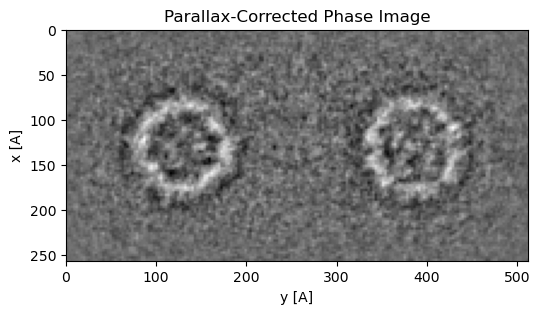

In [9]:
#| label: app:py4dstem_parallax_correction

with plt.ioff():
    parallax = parallax.aberration_correct(
        figsize=(6,3),
        cmap='gray'
    )
    fig_correction = plt.gcf()
fig_correction